**Disclaimer:** Please note that this entire script may take about 20 minutes to run completely. This will not be able to run on Colab, please run it on Jupyter.

# 1. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import StandardScaler 

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K

from decimal import Decimal

from multiprocessing import Pool

from kneed import KneeLocator #Install #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot

# 2. Import Data

For teaching team
Please change the location variable to your desired directory to read in hackaton files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# please change your desired directory here
location = '/content/drive/My Drive/DSA3101 Group 9/data/'

In [ ]:
# run the mount drive below
# put the data folder on the root directory of your google drive
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')

In [ ]:
df_paneldemo['Ethnic'] = df_paneldemo.Ethnicity.apply(lambda x: x.split(" ")[-1])

### Data Transformation

For K-Means Clustering (Customers).

Asides from calculating their monetary and frequency values, we will add in a new column that indicates on a daily basis, how many calories does each customer intake.

Below is a plot of the spread of calories across the various categories that we have. 

Text(0, 0.5, 'Calories/100g')

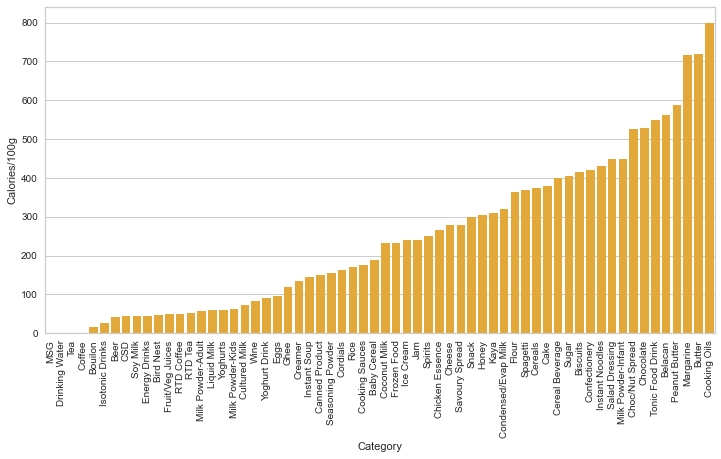

In [ ]:
df = df_catinfo.sort_values(['Calories/100g']).reset_index(drop=True)
plt.figure(figsize=(12,6))
bar = sns.barplot(x=df.Category, y=df['Calories/100g'], color= '#FFB11E')
for item in bar.get_xticklabels():
    item.set_rotation(90)
plt.ylabel("Calories/100g")

In [ ]:
''' Since there are zero values, in both Volume and Pack Size, we need to take that into account while 
multiplying in the next block of code. '''

df_hackdata.loc[(df_hackdata['Volume'] == 0) & (df_hackdata['Pack Size']== 0)]['Category'].unique()

array(['Coffee', 'MSG', 'Bouilon', 'Tea', 'Biscuits', 'Coconut Milk',
       'Chocolate', 'Yoghurts', 'Cereals', 'Tonic Food Drink', 'Snack',
       'Ice Cream', 'Cooking Sauces', 'Creamer', 'Confectionery'],
      dtype=object)

The end goal for the K-Means clustering by customer is to estimate the **average caloric consumption** of the customer/individual. Reason why BMI was not preferred over this method is that BMI levels itself give us limited information, and it would be better to perform K-Means on numeric values rather than ordinal figures. 

We have taken into account the following things:

1. Some categories may be high on caloric weightage, such as cooking oils (800 Calories/100g) but it's not reasonable to think that one would consume all 100g. However, this is not a concern, as the frequency of their purchase of the item would be indicative of how fast they finished consuming the items they have bought. Items that have a smaller serving size (like cooking oil) will be consumed slower.
2. Calories/100g will then be multiplied by volume or pack size.
3. We will not penalise customers for buying large volume of goods if they have a large family. Calories computed will be divided by number of household members. 
4. Caloric figures computed are not to be taken at face value, they will be scaled according to the distribution, especially when being used in K-Means. 

Assumptions made:
1. These are the only grocery transactions they have made, and hence, it is reasonable to liken the average calories consumed per day to what they may actually consume typically. 


In [ ]:
df_hackdata2 = df_hackdata.merge(df_catinfo, left_on='Category', right_on = 'Category')

def convert(x):
    if x['Volume'] == 0 & x['Pack Size'] == 0: 
        y = x['Calories/100g']
    elif x['Volume'] == 0:
        y = x['Calories/100g']*x['Pack Size']
    else:
        y = x['Calories/100g']*x['Volume']
    return(y) 
        
df_hackdata2['Volume*Calories'] = df_hackdata2.apply(lambda row: convert(row),axis=1)

df_hackdata2 = df_hackdata2.groupby(['Panel ID', 'Date'])['Volume*Calories'].\
                            agg('sum').\
                            reset_index().\
                            groupby('Panel ID')['Volume*Calories'].\
                            agg('mean').reset_index()

df_hackdata2.head()

Panel ID  Volume*Calories
0  Panel 101011101      3134.954128
1  Panel 101016101      2670.116901
2  Panel 101019101      4745.492810
3  Panel 101024101      3223.792157
4  Panel 105009103      2360.576282

In [ ]:
df_paneldemo['#HH'].unique()

array(['1-3 Member HH', '4 Member HH', '7+ Member HH', '5 Member HH',
       '6 Member HH'], dtype=object)

In [ ]:
df_hackdata3 = df_hackdata2.\
            merge(df_paneldemo,left_on = 'Panel ID', right_on = 'ID')[['Panel ID', 'Volume*Calories', '#HH', 'BMI']]

segt_map = {
    r'1-3 Member HH' : 2,
    r'4 Member HH': 4,
    r'7\+ Member HH': 7,
    r'5 Member HH': 5,
    r'6 Member HH': 6
}

# Attempt to generate Average Calories by dividing number of household members

df_hackdata3['Members'] = df_hackdata3['#HH']
df_hackdata3['Members'] = df_hackdata3['Members'].replace(segt_map, regex=True).astype(int)
df_hackdata3['AvgCalories'] = df_hackdata3['Volume*Calories'] / df_hackdata3['Members']
df_hackdata3.head()

Panel ID  Volume*Calories            #HH          BMI  Members  \
0  Panel 101011101      3134.954128  1-3 Member HH        Obese        2   
1  Panel 101016101      2670.116901  1-3 Member HH      Healthy        2   
2  Panel 101019101      4745.492810    4 Member HH        Obese        4   
3  Panel 101024101      3223.792157  1-3 Member HH  Over Weight        2   
4  Panel 105009103      2360.576282  1-3 Member HH  Over Weight        2   

   AvgCalories  
0  1567.477064  
1  1335.058451  
2  1186.373203  
3  1611.896078  
4  1180.288141

Earlier, we had said that calories will be divided by the number of members in the household, however that is a bit unfair as the larger families get heavily penalised and the mean for 2 household members vs 7 household members becomes highly different.

In [ ]:
df_hackdata3.groupby('Members')['Volume*Calories'].describe()

count         mean          std         min          25%  \
Members                                                             
2        918.0  2784.729051  1885.206940  180.164220  1593.843323   
4        738.0  3272.616762  2075.991413  283.133333  1825.060049   
5        726.0  3756.911306  2348.257241  353.550000  2263.831250   
6        428.0  4349.516879  2980.315916  257.742857  2613.305405   
7        426.0  4530.150014  2799.853476  434.150000  2796.598381   

                 50%          75%           max  
Members                                          
2        2410.353581  3465.543065  18896.292308  
4        2816.389667  4139.785549  14840.510714  
5        3320.173113  4666.989753  30225.408824  
6        3679.153511  5229.842586  25967.290000  
7        3949.422795  5496.034732  22083.000000

In [ ]:
df_hackdata3.groupby('BMI')['AvgCalories'].describe()

count         mean         std        min         25%  \
BMI                                                                    
Healthy       1243.0   884.888273  655.106701  68.234568  484.818611   
Obese          449.0  1124.697602  930.168927  85.456250  563.676900   
Over Weight    796.0   990.568172  673.157248  71.637143  558.560825   
Under Weight   748.0   828.946339  650.677119  42.957143  430.293393   

                     50%          75%          max  
BMI                                                 
Healthy       723.048529  1082.634307  6713.850000  
Obese         876.025000  1392.719545  9448.146154  
Over Weight   811.071056  1230.580766  5774.365169  
Under Weight  648.911987  1029.797167  6227.950000

To cope with this issue, we can instead, choose to standardize the values within each group (#members), so that numbers can be comparable across all the groups.

In [ ]:
df_hackdata3['AvgCalories'] = df_hackdata3.groupby('Members')['Volume*Calories'].\
                                transform(lambda x: (x - x.mean()) / x.std())

df_hackdata3.groupby('BMI')['AvgCalories'].describe()

count      mean       std       min       25%       50%  \
BMI                                                                      
Healthy       1243.0 -0.100421  0.932007 -1.449314 -0.658542 -0.288038   
Obese          449.0  0.328797  1.280575 -1.411755 -0.513660  0.043966   
Over Weight    796.0  0.081573  0.931227 -1.438893 -0.567947 -0.108419   
Under Weight   748.0 -0.117297  0.933831 -1.462934 -0.756380 -0.299911   

                   75%        max  
BMI                                
Healthy       0.184592  11.271549  
Obese         0.793484   8.546310  
Over Weight   0.458479   7.253517  
Under Weight  0.296029   6.731744

If one may see the table & plot below, the mean numbers seem indicative of the respective BMI levels i.e

- Underweight --> lowest caloric values
- Healthy --> second lowest
- Overweight --> second highest
- Obese --> highest 

There are overlap caloric values across the groups, but it is sufficient that the quarterly percentiles are indicative of each group.


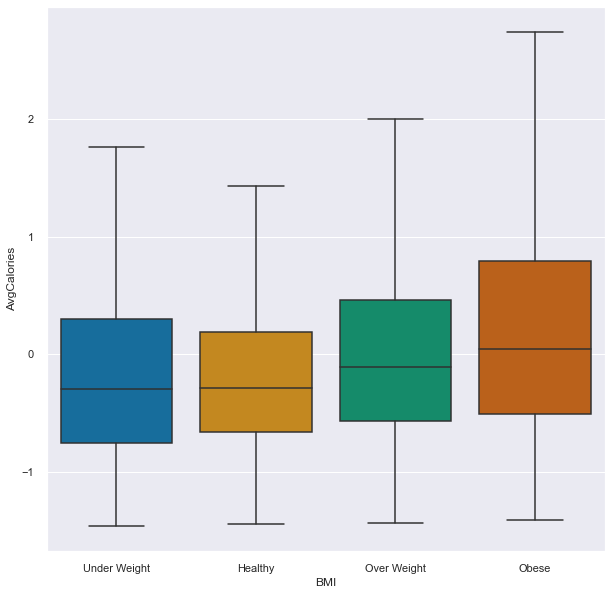

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale = 1)
sns.boxplot(y= "AvgCalories", x='BMI', data=df_hackdata3, palette="colorblind",showfliers=False, 
            order = ["Under Weight", "Healthy","Over Weight","Obese"])

In [ ]:
df_hackdata3.groupby('BMI').describe()['AvgCalories']

count      mean       std       min       25%       50%  \
BMI                                                                      
Healthy       1243.0 -0.100421  0.932007 -1.449314 -0.658542 -0.288038   
Obese          449.0  0.328797  1.280575 -1.411755 -0.513660  0.043966   
Over Weight    796.0  0.081573  0.931227 -1.438893 -0.567947 -0.108419   
Under Weight   748.0 -0.117297  0.933831 -1.462934 -0.756380 -0.299911   

                   75%        max  
BMI                                
Healthy       0.184592  11.271549  
Obese         0.793484   8.546310  
Over Weight   0.458479   7.253517  
Under Weight  0.296029   6.731744

In [ ]:
# Here, we will introduce monetary and frequency spendings as additional features to cluster the customers by.

df_hackdata4 = df_hackdata.groupby('Panel ID').agg({'Panel ID': lambda x: len(x),
                                                    'Spend': lambda x : x.sum()/len(x)} )

df_hackdata4.rename(columns={'Panel ID':'Frequency', 'Spend':'Monetary'},inplace=True)
df_hackdata4 = df_hackdata4.reset_index()

df_hackdata4 = df_hackdata4.merge(df_hackdata3,left_on = 'Panel ID', 
                   right_on = 'Panel ID')[['Panel ID', 'Frequency', 'Monetary', 'AvgCalories']]
df_hackdata4.head()

Panel ID  Frequency  Monetary  AvgCalories
0  Panel 101011101        404  9.658911     0.185775
1  Panel 101016101        326  5.792025    -0.060796
2  Panel 101019101       1730  4.238902     0.709481
3  Panel 101024101       1004  5.966833     0.232899
4  Panel 105009103       1273  3.730636    -0.224990

# 2. K-Means Clustering (Customers)

In this section, we will use K-Means Clustering on transaction data as well as the categories data to do clustering based Caloric Consumption levels, Frequency and Monetary levels. This will eventually be fed into the reccomendation engine.

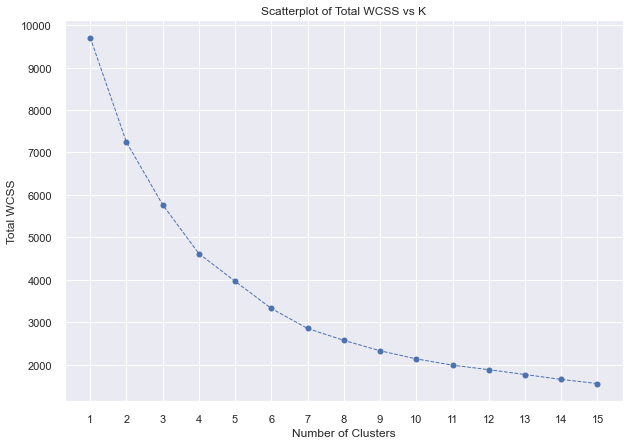

In [ ]:
dataarray = df_hackdata4.drop(columns= ['Panel ID']).to_numpy()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray)

wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")
kl.elbow

6

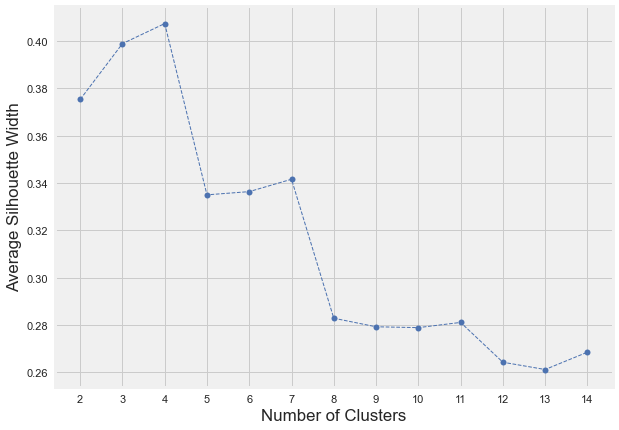

In [ ]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)
    
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### 6 clusters

Since the elbow suggests 6, we can try 6 clusters first. 

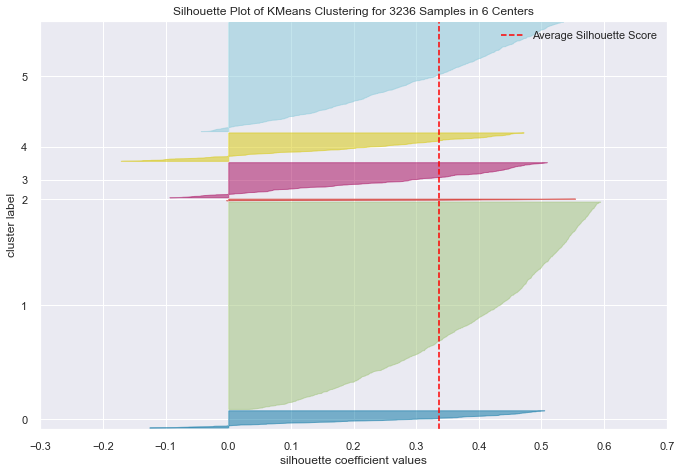

For n_clusters = 6, The average silhouette_score is: 0.3364105800357594


In [ ]:
kmeans6 = KMeans(init="random",n_clusters = 6, n_init = 10, max_iter = 300, random_state = 42)
kmeans6.fit(scaled_features)
clustergroups6 = kmeans6.labels_

model = KMeans(6, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, scaled_features, colors='yellowbrick')
print("For n_clusters = 6, The average silhouette_score is: " + str(silhouette_score(scaled_features, model.labels_,metric = 'euclidean')))

In [ ]:
model_6 = df_hackdata4.copy()
model_6['Clusters'] = pd.DataFrame(clustergroups6)
model_6.groupby('Clusters').mean()

Frequency   Monetary  AvgCalories
Clusters                                     
0          223.028070  22.422382    -0.379397
1          260.013043  13.544212     2.360978
2          197.530710   9.417547    -0.432822
3          706.268841   9.224468     0.171913
4           74.214286  75.196511    -0.444795
5         1663.028369   7.140327     1.023704

In [ ]:
df = df_hackdata.merge(model_6, left_on = 'Panel ID', right_on = 'Panel ID')
df.head()

Panel ID       Date        Category  Pack Size  Volume  Spend  \
0  Panel 101011101 2017-07-02             CSD          1     1.5    1.5   
1  Panel 101011101 2017-07-02        Soy Milk          1     1.0    2.8   
2  Panel 101011101 2017-07-02  Cooking Sauces          1     0.3    3.2   
3  Panel 101011101 2017-07-02    Coconut Milk          2     0.4    5.3   
4  Panel 101011101 2017-07-02       Chocolate          1     0.2    6.6   

   Frequency  Monetary  AvgCalories  Clusters  
0        404  9.658911     0.185775         3  
1        404  9.658911     0.185775         3  
2        404  9.658911     0.185775         3  
3        404  9.658911     0.185775         3  
4        404  9.658911     0.185775         3

In [ ]:
df2 = df.groupby(["Clusters", "Category"]).size().reset_index(name="Count").\
                                    sort_values(by=["Clusters", "Count"], ascending=False)
df2.head()

Clusters         Category  Count
305         5         Biscuits  17510
353         5            Snack  16467
327         5             Eggs  13460
335         5  Instant Noodles  13202
322         5   Cooking Sauces  12234

### 5 clusters

Since 6 clusters has a rather low silhouette score, as well as one unnoticeably tiny cluster, which may not be quite significant, we would like to try 5 clusters instead. 

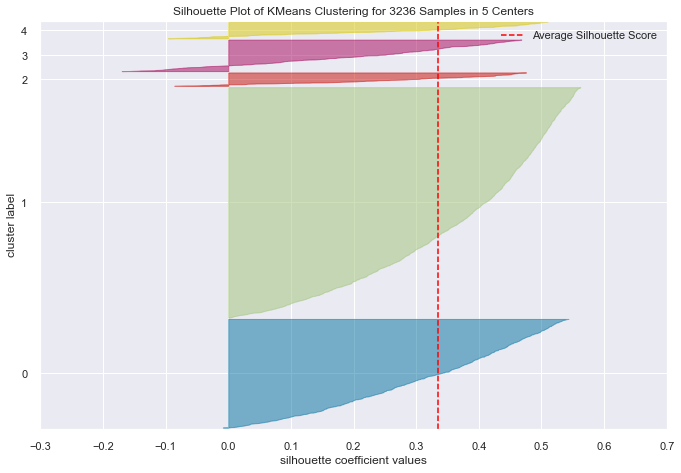

For n_clusters = 5, The average silhouette_score is: 0.33444092422917093


In [ ]:
kmeans5 = KMeans(init="random",n_clusters = 5, n_init = 10, max_iter = 300, random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_

model = KMeans(5, random_state=42)
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
silhouette_visualizer(model, scaled_features, colors='yellowbrick')
print("For n_clusters = 5, The average silhouette_score is: " + str(silhouette_score(scaled_features, model.labels_,metric = 'euclidean')))

In [ ]:
model_5 = df_hackdata4.copy()
model_5['Clusters'] = pd.DataFrame(clustergroups5)
model_5.groupby('Clusters').mean()

Frequency   Monetary  AvgCalories
Clusters                                     
0          721.381007   9.241267     0.153715
1          202.305958  10.286185    -0.432300
2         1689.947368   7.116606     1.060481
3          266.380392  13.422275     2.231584
4          161.720721  35.582385    -0.351982

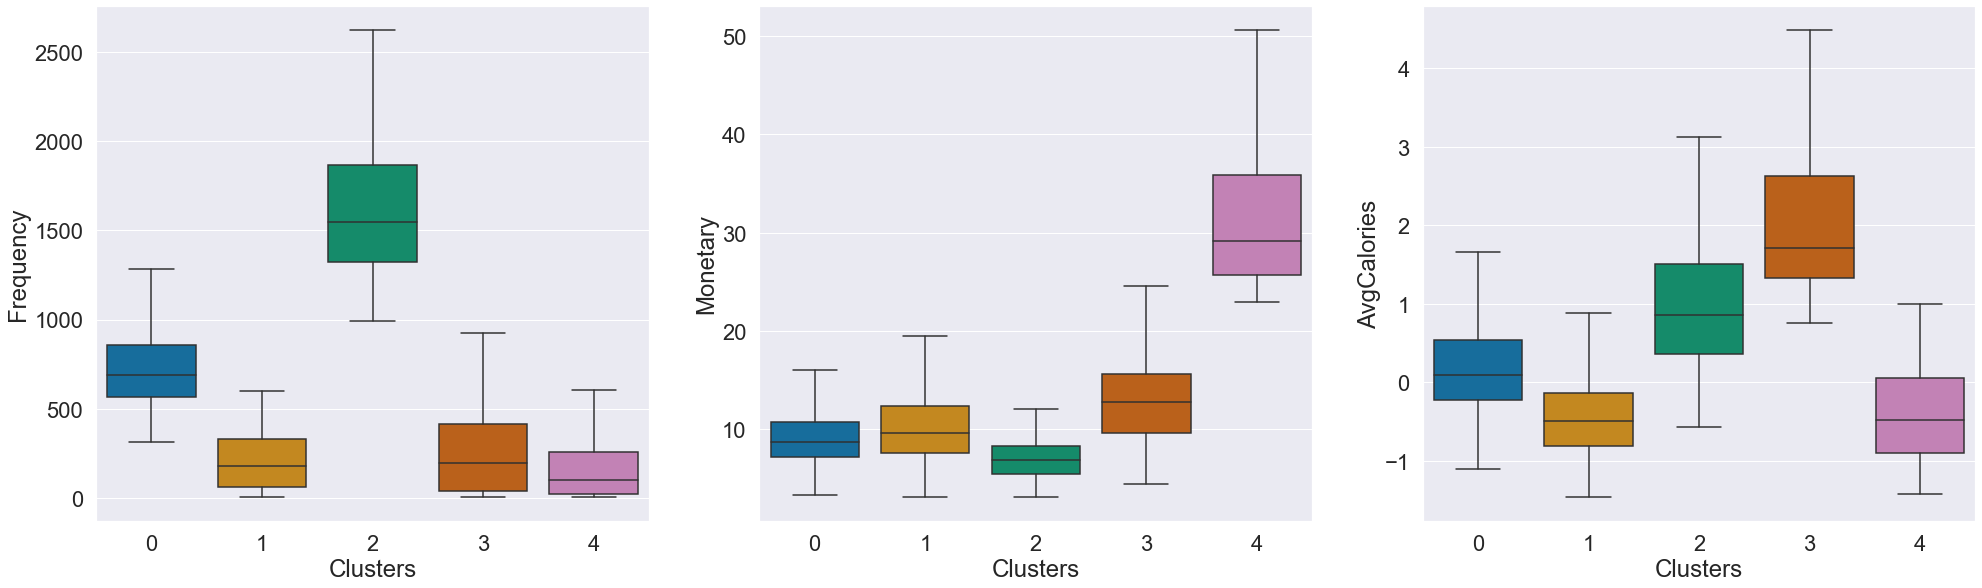

In [ ]:
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(1,4):
    plt.subplot(3,3,i)
    sns.boxplot(y=model_5.columns[i], x='Clusters', data=model_5, palette="colorblind",showfliers=False)

Since both 5 and 6 clusters have similar silhouette scores, and clusters formed with 6-way splitting causes signficantly small cluster groups (you may refer to the cluster 2), we have deemed 6 clusters to be unnecessary. 

We shall focus our reccomendation engine on 5 clusters instead of 6. 
Before doing so, let us take a look at the ANOVA values for determining if the features, _caloric consumption, frequency_ and _monetary values_ are significant for the 5 cluster K-Means model.

The p values are all less than 0.05, proving them to be significant features to carry out K-Means clustering on.

In [ ]:
#perform N-way ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

def clustereval(data,sig):
    eval = []
    cols = list(data.columns)[:-1]
    for c in cols:
        model = ols(c +' ~ C(Clusters)', data=data).fit()
        pval = sm.stats.anova_lm(model).iloc[0,4]
        print(c + " :")
        print("P-Value : " + str(pval))
        print("Significant at "+ str(sig) +": " + str(pval < sig))
        print()
        
clustereval(model_5.drop(columns = ['Panel ID']),0.05)

Frequency :
P-Value : 0.0
Significant at 0.05: True

Monetary :
P-Value : 0.0
Significant at 0.05: True

AvgCalories :
P-Value : 0.0
Significant at 0.05: True



# 3. Recommender Engines

In [ ]:
spending_df = df_hackdata.copy()
spending_df["Panel ID"]=spending_df["Panel ID"].apply(lambda x:x.split(" ")[-1])
spending_df

Panel ID       Date        Category  Pack Size  Volume  Spend
0        101011101 2017-07-02             CSD          1     1.5    1.5
1        101011101 2017-07-02        Soy Milk          1     1.0    2.8
2        101011101 2017-07-02  Cooking Sauces          1     0.3    3.2
3        101011101 2017-07-02    Coconut Milk          2     0.4    5.3
4        101011101 2017-07-02       Chocolate          1     0.2    6.6
...            ...        ...             ...        ...     ...    ...
1318019  801912801 2020-02-23             MSG          1     0.1    2.2
1318020  801912801 2020-02-23            Eggs          1    30.0    8.4
1318021  801912801 2020-02-23       Ice Cream          1     1.5    8.0
1318022  801912801 2020-02-23  Cooking Sauces          1     0.7    4.8
1318023  801912801 2020-02-23         Bouilon          1     0.0    1.2

[1318024 rows x 6 columns]

Group by ID and Category, the result will be the total amount of money that each customer spending on our store during these three years.

In [ ]:
group_df=spending_df.groupby(["Panel ID","Category"])
group_df.size()
sum_grp=group_df.sum()
sum_grp=sum_grp.rename(columns={'Spend':'Total Spend'})
sum_grp=sum_grp.drop(["Pack Size","Volume"], axis=1)
sum_df=sum_grp.reset_index()
sum_df

Panel ID     Category  Total Spend
0      101011101     Biscuits        106.5
1      101011101      Bouilon         15.4
2      101011101       Butter         45.4
3      101011101          CSD         94.8
4      101011101         Cake         15.7
...          ...          ...          ...
97133  801912801    Ice Cream          8.0
97134  801912801  Liquid Milk          7.3
97135  801912801          MSG          4.4
97136  801912801         Rice         53.5
97137  801912801        Sugar          8.6

[97138 rows x 3 columns]

Find names of all distinct categories.

In [ ]:
cate_list=sum_df["Category"].unique().tolist()

## Preprocessing: Pivot table

Since we have all records of the money for each customer spending on each products, we can switch to a new pivot table so the column names are categoies and Panel ID is the table index. 


In [ ]:
pivot_df = sum_df.pivot(index='Panel ID', columns='Category', values='Total Spend')
pivot_df.fillna(0,inplace=True)
pivot_df.head()

Category   Baby Cereal  Beer  Belacan  Bird Nest  Biscuits  Bouilon  Butter  \
Panel ID                                                                      
101011101          0.0   0.0      0.0        0.0     106.5     15.4    45.4   
101016101          0.0   0.0      0.0        0.0      75.3     38.5     0.0   
101019101          0.0   0.0     15.5        0.0     134.2      0.0     0.0   
101024101          0.0   0.0      0.0        0.0     271.0     11.5     0.0   
105009103          0.0   0.0      0.0        0.0     316.6     24.4     0.0   

Category    CSD  Cake  Canned Product  ...  Snack  Soy Milk  Spagetti  \
Panel ID                               ...                              
101011101  94.8  15.7            68.4  ...   41.9      10.6       3.1   
101016101   0.0   0.0             0.0  ...    2.1       0.0       0.0   
101019101  17.2   4.9           159.6  ...   27.2       5.0       0.0   
101024101  82.4  29.7           425.4  ...  348.7      76.2      50.2   
105009103   0.0   2.6           430.3  ...    0.0      20.2       0.0   

Category   Spirits  Sugar   Tea  Tonic Food Drink  Wine  Yoghurt Drink  \
Panel ID                                                                 
101011101      0.0  578.5  26.4              29.4   0.0            0.0   
101016101      0.0  213.9   6.0             114.6   0.0            0.0   
101019101      0.0  862.6  16.5             574.9   0.0           15.9   
101024101      0.0   36.3  53.6             285.8   0.0           57.3   
105009103      0.0   39.8   2.6             825.8   0.0            0.0   

Category   Yoghurts  
Panel ID             
101011101       0.0  
101016101       0.0  
101019101       0.0  
101024101       5.0  
105009103       0.0  

[5 rows x 62 columns]

From the describe(), there are many products which only few customers have bought, so the revenus could be increased by recommending certain products toward targeted customers.

In [ ]:
pivot_df.describe() 

Category  Baby Cereal          Beer      Belacan    Bird Nest     Biscuits  \
count      3236.00000   3236.000000  3236.000000  3236.000000  3236.000000   
mean          4.80618     49.489648     3.427101     5.695983   201.731304   
std          34.81739    423.781008    14.155805    63.663779   247.994288   
min           0.00000      0.000000     0.000000     0.000000     0.000000   
25%           0.00000      0.000000     0.000000     0.000000    30.775000   
50%           0.00000      0.000000     0.000000     0.000000   117.550000   
75%           0.00000      0.000000     0.000000     0.000000   280.425000   
max        1116.00000  19544.000000   333.800000  2440.800000  1942.400000   

Category      Bouilon       Butter          CSD         Cake  Canned Product  \
count     3236.000000  3236.000000  3236.000000  3236.000000     3236.000000   
mean        22.903461    24.207602    23.947311    31.362361       85.661434   
std         43.243568    65.028203    60.038557   104.131299      153.436276   
min          0.000000     0.000000     0.000000     0.000000        0.000000   
25%          0.000000     0.000000     0.000000     0.000000        3.000000   
50%          5.500000     0.000000     2.500000     0.000000       29.950000   
75%         25.700000    19.100000    22.200000    16.025000      103.100000   
max        391.200000  1378.200000  1188.500000  2047.700000     2617.000000   

Category  ...        Snack     Soy Milk     Spagetti       Spirits  \
count     ...  3236.000000  3236.000000  3236.000000   3236.000000   
mean      ...    93.869036    12.592367    11.377194     10.499042   
std       ...   171.912122    38.372878    25.079455    231.296506   
min       ...     0.000000     0.000000     0.000000      0.000000   
25%       ...     3.100000     0.000000     0.000000      0.000000   
50%       ...    29.600000     0.000000     0.000000      0.000000   
75%       ...   106.300000     9.200000    11.700000      0.000000   
max       ...  2004.600000   907.100000   308.700000  12047.000000   

Category        Sugar          Tea  Tonic Food Drink         Wine  \
count     3236.000000  3236.000000       3236.000000  3236.000000   
mean       126.605995    45.648331        205.677256     8.135816   
std        196.881185    84.677675        282.589558   111.152135   
min          0.000000     0.000000          0.000000     0.000000   
25%         10.800000     0.000000         19.375000     0.000000   
50%         48.500000    15.550000        100.600000     0.000000   
75%        160.600000    53.025000        274.175000     0.000000   
max       2473.600000  1385.100000       2322.700000  3294.500000   

Category  Yoghurt Drink     Yoghurts  
count       3236.000000  3236.000000  
mean          14.004821    13.286743  
std           58.463960    46.632249  
min            0.000000     0.000000  
25%            0.000000     0.000000  
50%            0.000000     0.000000  
75%           11.800000     8.725000  
max         2695.700000  1294.200000  

[8 rows x 62 columns]

In [ ]:
model_6

Panel ID  Frequency   Monetary  AvgCalories  Clusters
0     Panel 101011101        404   9.658911     0.185775         3
1     Panel 101016101        326   5.792025    -0.060796         2
2     Panel 101019101       1730   4.238902     0.709481         5
3     Panel 101024101       1004   5.966833     0.232899         3
4     Panel 105009103       1273   3.730636    -0.224990         5
...               ...        ...        ...          ...       ...
3231  Panel 801900701         24   9.037500    -0.484418         2
3232  Panel 801901201        196   5.943878    -0.236164         2
3233  Panel 801903201         28  14.285714     0.740854         2
3234  Panel 801903801         46   6.293478    -0.850377         2
3235  Panel 801912801         25  10.572000     0.230756         2

[3236 rows x 5 columns]

In [ ]:
# 3D scattered plot (runnable only on Jupyter)
fig = px.scatter_3d(model_6, 
                    x='Frequency', 
                    y='Monetary', 
                    z='AvgCalories',
                    color='Clusters', 
                    size_max=18,
              symbol='Clusters', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## Recommendation based on 5 clusters

In [ ]:
cluster5_df  = model_5.loc[:, ['Panel ID', 'Clusters']]
cluster5_df["Panel ID"] = cluster5_df["Panel ID"].apply(lambda x:x.split(" ")[-1])

Merging clusters into pivot table, now we have all informations includeing how much money customer spends on the product, and which cluster the customer belongs to.

In [ ]:
pivot_df5 = pivot_df.copy().reset_index()
pivot_df5 = pd.merge(pivot_df5, cluster5_df, how='left', on='Panel ID')
pivot_df5.head()

Panel ID  Baby Cereal  Beer  Belacan  Bird Nest  Biscuits  Bouilon  \
0  101011101          0.0   0.0      0.0        0.0     106.5     15.4   
1  101016101          0.0   0.0      0.0        0.0      75.3     38.5   
2  101019101          0.0   0.0     15.5        0.0     134.2      0.0   
3  101024101          0.0   0.0      0.0        0.0     271.0     11.5   
4  105009103          0.0   0.0      0.0        0.0     316.6     24.4   

   Butter   CSD  Cake  ...  Soy Milk  Spagetti  Spirits  Sugar   Tea  \
0    45.4  94.8  15.7  ...      10.6       3.1      0.0  578.5  26.4   
1     0.0   0.0   0.0  ...       0.0       0.0      0.0  213.9   6.0   
2     0.0  17.2   4.9  ...       5.0       0.0      0.0  862.6  16.5   
3     0.0  82.4  29.7  ...      76.2      50.2      0.0   36.3  53.6   
4     0.0   0.0   2.6  ...      20.2       0.0      0.0   39.8   2.6   

   Tonic Food Drink  Wine  Yoghurt Drink  Yoghurts  Clusters  
0              29.4   0.0            0.0       0.0         0  
1             114.6   0.0            0.0       0.0         1  
2             574.9   0.0           15.9       0.0         2  
3             285.8   0.0           57.3       5.0         0  
4             825.8   0.0            0.0       0.0         0  

[5 rows x 64 columns]

Before calculating the most similar customer by cosine similarity, it is noticed that the value zero heavily influence the result in vector 
multiplication because the corresponding value times 0 also becomes 0. This leads to the consumption information lost. For exmaple, (123,1,0) and (0,1.5,0.1) are not similar, but cosine similarity will tell us these 2 vectors are extremly similar because cosine similarity algo cannot eliminate the effect of 0.

To solve this problem, I add 1 to each number because 1 can keep original infomation without introducing huge error.( Based on the pivot describe table, the average money spending on each type are much more than 1.) 

In [ ]:
add1_df5 = pivot_df5.copy()
for i in cate_list:
    add1_df5[i] = add1_df5[i].apply(lambda x:x+1)
add1_df5.head()
add1_df5=add1_df5.set_index(["Panel ID"])
add1_df5.head()

Baby Cereal  Beer  Belacan  Bird Nest  Biscuits  Bouilon  Butter  \
Panel ID                                                                      
101011101          1.0   1.0      1.0        1.0     107.5     16.4    46.4   
101016101          1.0   1.0      1.0        1.0      76.3     39.5     1.0   
101019101          1.0   1.0     16.5        1.0     135.2      1.0     1.0   
101024101          1.0   1.0      1.0        1.0     272.0     12.5     1.0   
105009103          1.0   1.0      1.0        1.0     317.6     25.4     1.0   

            CSD  Cake  Canned Product  ...  Soy Milk  Spagetti  Spirits  \
Panel ID                               ...                                
101011101  95.8  16.7            69.4  ...      11.6       4.1      1.0   
101016101   1.0   1.0             1.0  ...       1.0       1.0      1.0   
101019101  18.2   5.9           160.6  ...       6.0       1.0      1.0   
101024101  83.4  30.7           426.4  ...      77.2      51.2      1.0   
105009103   1.0   3.6           431.3  ...      21.2       1.0      1.0   

           Sugar   Tea  Tonic Food Drink  Wine  Yoghurt Drink  Yoghurts  \
Panel ID                                                                  
101011101  579.5  27.4              30.4   1.0            1.0       1.0   
101016101  214.9   7.0             115.6   1.0            1.0       1.0   
101019101  863.6  17.5             575.9   1.0           16.9       1.0   
101024101   37.3  54.6             286.8   1.0           58.3       6.0   
105009103   40.8   3.6             826.8   1.0            1.0       1.0   

           Clusters  
Panel ID             
101011101         0  
101016101         1  
101019101         2  
101024101         0  
105009103         0  

[5 rows x 63 columns]

For the following function, it can find the average spending of 20th most similar customers in the cluster by inserting a panel id.

In [ ]:
def recommend_profile_5(panelid):
    cluster = int(add1_df5.loc[panelid,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    cosinelist = []
    uservec = df.loc[panelid,:].to_numpy()
    indexofuser = df.index.get_loc(panelid)
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave

After finding potential products, we can recommend them to the customer if he has never bought that before. The profit is estimated by the average money those similar customers spending.

In [ ]:
def recommend_list_5(id):
    ave = recommend_profile_5(id).tolist()
    
    cluster = int(add1_df5.loc[id,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[id,:].to_numpy().tolist()
    
    recommend=[]
    for i in range(len(cate_list)):
        if uservec[i]==1 and ave[i]!=1:
            recommend.append([cate_list[i], ave[i]-1])
    return sorted(recommend, key = lambda x:x[1],reverse=True)

In [ ]:
def per_profit_5(panelid):
    cluster = int(add1_df5.loc[panelid,"Clusters":])
    df = add1_df5[add1_df5["Clusters"]==cluster]
    df=df.drop(["Clusters"],axis=1)
    uservec = df.loc[panelid,:].to_numpy()
    ave = recommend_profile_5(panelid)
    profit=[]
    for i in range(len(uservec)):
        if uservec[i] == 1:
            profit.append(round(ave[i]-1,1))
        else:
            profit.append(0)
    sum(profit)
    return sum(profit)

For customer 136083101, it belongs to a small cluster in model_6, and notw it switch to a new cluster. This makes a huge change in the way of recommendation. However, the cluster of customer 101011101 does not seem to change that much.

In [ ]:
recommend_profile_5('136083101')

array([   5.54,    1.  ,    1.34,    6.24,   67.58,    5.29,    5.89,
         10.15,   18.24,   12.02,   21.15,    7.59,   11.77,   37.86,
          4.28,   16.79,   10.52,   22.24,   20.13,    8.4 ,   56.2 ,
         21.56,    8.38,    1.  ,   17.81,    4.11,   52.49,    1.16,
          7.94,   41.75,   15.84,    1.  ,    1.69,   29.04,   57.69,
          1.72,    9.79,    2.68,    2.31,   42.89,    1.05,    7.68,
         21.46,    4.53, 2736.8 ,    9.82,    3.06,    4.06,  121.94,
          6.23,    2.55,    4.04,   32.9 ,    2.76,    5.38,    1.  ,
         19.23,   17.02,  107.46,    1.24,    8.74,    5.37])

In [ ]:
recommend_list_5('101011101')

[['Yoghurt Drink', 24.84],
 ['Spagetti', 9.52],
 ['Creamer', 7.41],
 ['Butter', 5.6],
 ['Peanut Butter', 5.58],
 ['Eggs', 3.5],
 ['Spirits', 3.4699999999999998],
 ['RTD Tea', 2.12],
 ['Honey', 1.83],
 ['Yoghurts', 1.2400000000000002],
 ['Kaya', 0.95],
 ['Biscuits', 0.53],
 ['Seasoning Powder', 0.31000000000000005],
 ['Liquid Milk', 0.19999999999999996],
 ['CSD', 0.07000000000000006]]

In [ ]:
per_profit_5('101011101')

67.1

Running the recommendation engine for all customers, if they all accept our recommendation, the quarterly revenue can increase by $108142

#### The following code might take 5-15mins to run, depending on the CPU threads you have

In [ ]:
def wrapper(i):
    p = per_profit_5(i)
    return [i, p]

index_list5 = add1_df5.index.to_list()
# 10 threads
with Pool(10) as p:    
    id_reve = p.map(wrapper, index_list5)

In [ ]:
id_reve = pd.DataFrame(id_reve)
id_reve = id_reve.rename(columns =  {0:'ID', 1: 'revenue'})
quarter_increase =  id_reve.revenue.sum()/12
quarter_increase

## Comparing the recommendation between without/with clusters

In this section, we will be comparing the recommendation results with/without cluster. This will let us know if clustering helped in any way for the reccomendation engine.

In [ ]:
def ori_recommend(uid):
    cluster = int(add1_df5.loc[uid,"Clusters":])
    df = add1_df5
    df=df.drop(["Clusters"],axis=1)
    cosinelist = []
    uservec = df.loc[uid,:].to_numpy()
    indexofuser = df.index.get_loc(uid)
    
    for i in range(0,len(df)):
        if i == indexofuser:
            continue
        v = df.iloc[i,:].to_numpy()
        cos = cosine_similarity([uservec], [v])
        cosinelist.append([i,cos[-1][-1]])
        
    cossort=sorted(cosinelist,key = lambda s: s[1],reverse = True)
    
    k=20
    min_k = 5
    np.random.seed(3101)
    np.set_printoptions(suppress=True)
    neighbors=[]
    for j in range(0,min(len(df)-1,k)):
        v = round(df.iloc[cossort[j][0],:],1).to_list()
        neighbors.append(v)
    neighbors = np.array(neighbors)
    ave1 = np.around(neighbors.mean(axis = 0),decimals = 2)
    return ave1

In [ ]:
ori_recommend('101011101')

array([  2.08,   1.  ,   4.54,   1.  ,  63.5 ,  29.14,   2.98,   9.96,
         8.19,  40.76,   4.72,   1.72,   5.06,   1.12,   1.45,   6.8 ,
        36.22,  44.14, 115.76,   1.84, 284.04, 118.59,  39.72,   1.  ,
         4.19,   3.56, 162.44,   1.  ,  86.97,  35.39,   6.04,   4.17,
         1.6 ,  10.05,  45.63,   1.  ,   9.14,   4.08,   5.04,  10.5 ,
         7.96,  22.7 ,  14.24,   3.22,  18.62,   2.36,   1.  ,   1.14,
       793.44,   5.26,   1.  ,  38.2 ,  49.44,   7.17,   4.56,   1.  ,
       364.2 ,  42.76,  50.02,   1.  ,   4.95,   2.34])

In [ ]:
def compare(uid):
  df = add1_df5
  df=df.drop(["Clusters"],axis=1)
  uservec = df.loc[uid,:].to_numpy().tolist()
  ori = ori_recommend(uid).tolist()
  new = recommend_profile_5(uid).tolist()
  for i in range(len(uservec)):
    uservec[i]-=1
    ori[i]-=1
    new[i]-=1
  df_compare = pd.DataFrame([uservec,ori,new],columns=sorted(cate_list),index=[uid,"before cluster","after cluster"])
  return df_compare

In [ ]:
compare('101011101')

Baby Cereal  Beer  Belacan  Bird Nest  Biscuits  Bouilon  \
101011101              0.00   0.0     0.00       0.00    106.50    15.40   
before cluster         1.08   0.0     3.54       0.00     62.50    28.14   
after cluster          0.53   0.0     5.60       0.07    149.15    49.30   

                Butter    CSD   Cake  Canned Product  ...  Snack  Soy Milk  \
101011101        45.40  94.80  15.70           68.40  ...  41.90     10.60   
before cluster    1.98   8.96   7.19           39.76  ...  48.44      6.17   
after cluster     4.86  16.31  26.54           68.26  ...  62.91     17.17   

                Spagetti  Spirits   Sugar     Tea  Tonic Food Drink  Wine  \
101011101           3.10      0.0  578.50   26.40             29.40   0.0   
before cluster      3.56      0.0  363.20   41.76             49.02   0.0   
after cluster       2.95      0.0  592.61  100.35            138.90   0.0   

                Yoghurt Drink  Yoghurts  
101011101                0.00      0.00  
before cluster           3.95      1.34  
after cluster            7.41      3.47  

[3 rows x 62 columns]

#4. K-Means Clustering (Categories)
In this section, we will use K-Means Clustering on all food Categories based on Calories, Price per Volume and Frequency of item bought to determine the optimal arrangement of items in a store. 

In [ ]:
df_hackdata['Frequency'] = 1
freq = df_hackdata.groupby('Category').sum()['Frequency'].to_frame()
Cat = df_catinfo.merge(freq, on = 'Category')
Cat.set_index('Category', inplace = True)
Cat.head()

Calories/100g  Price per Volume  Frequency
Category                                               
Baby Cereal            188             29.41       1074
Beer                    43             15.12       2671
Belacan                563             39.47       3046
Bird Nest               46             73.45        233
Biscuits               416             15.57     106109

As the price per volume of Eggs and Instant Noodles are different from the rest. We had to standardise the pricing by finding the price of 1 kg of the item respectively, which is then hard-coded.

In [ ]:
Cat.loc['Eggs','Price per Volume'] = Cat.loc['Eggs','Price per Volume'] * (1000/ 60)
Cat.loc['Instant Noodles', 'Price per Volume'] = Cat.loc['Instant Noodles', 'Price per Volume'] * (1000/100)

As seen below, all the columns exhibit a right skew. We will be using StandardScaler to scale the values. 

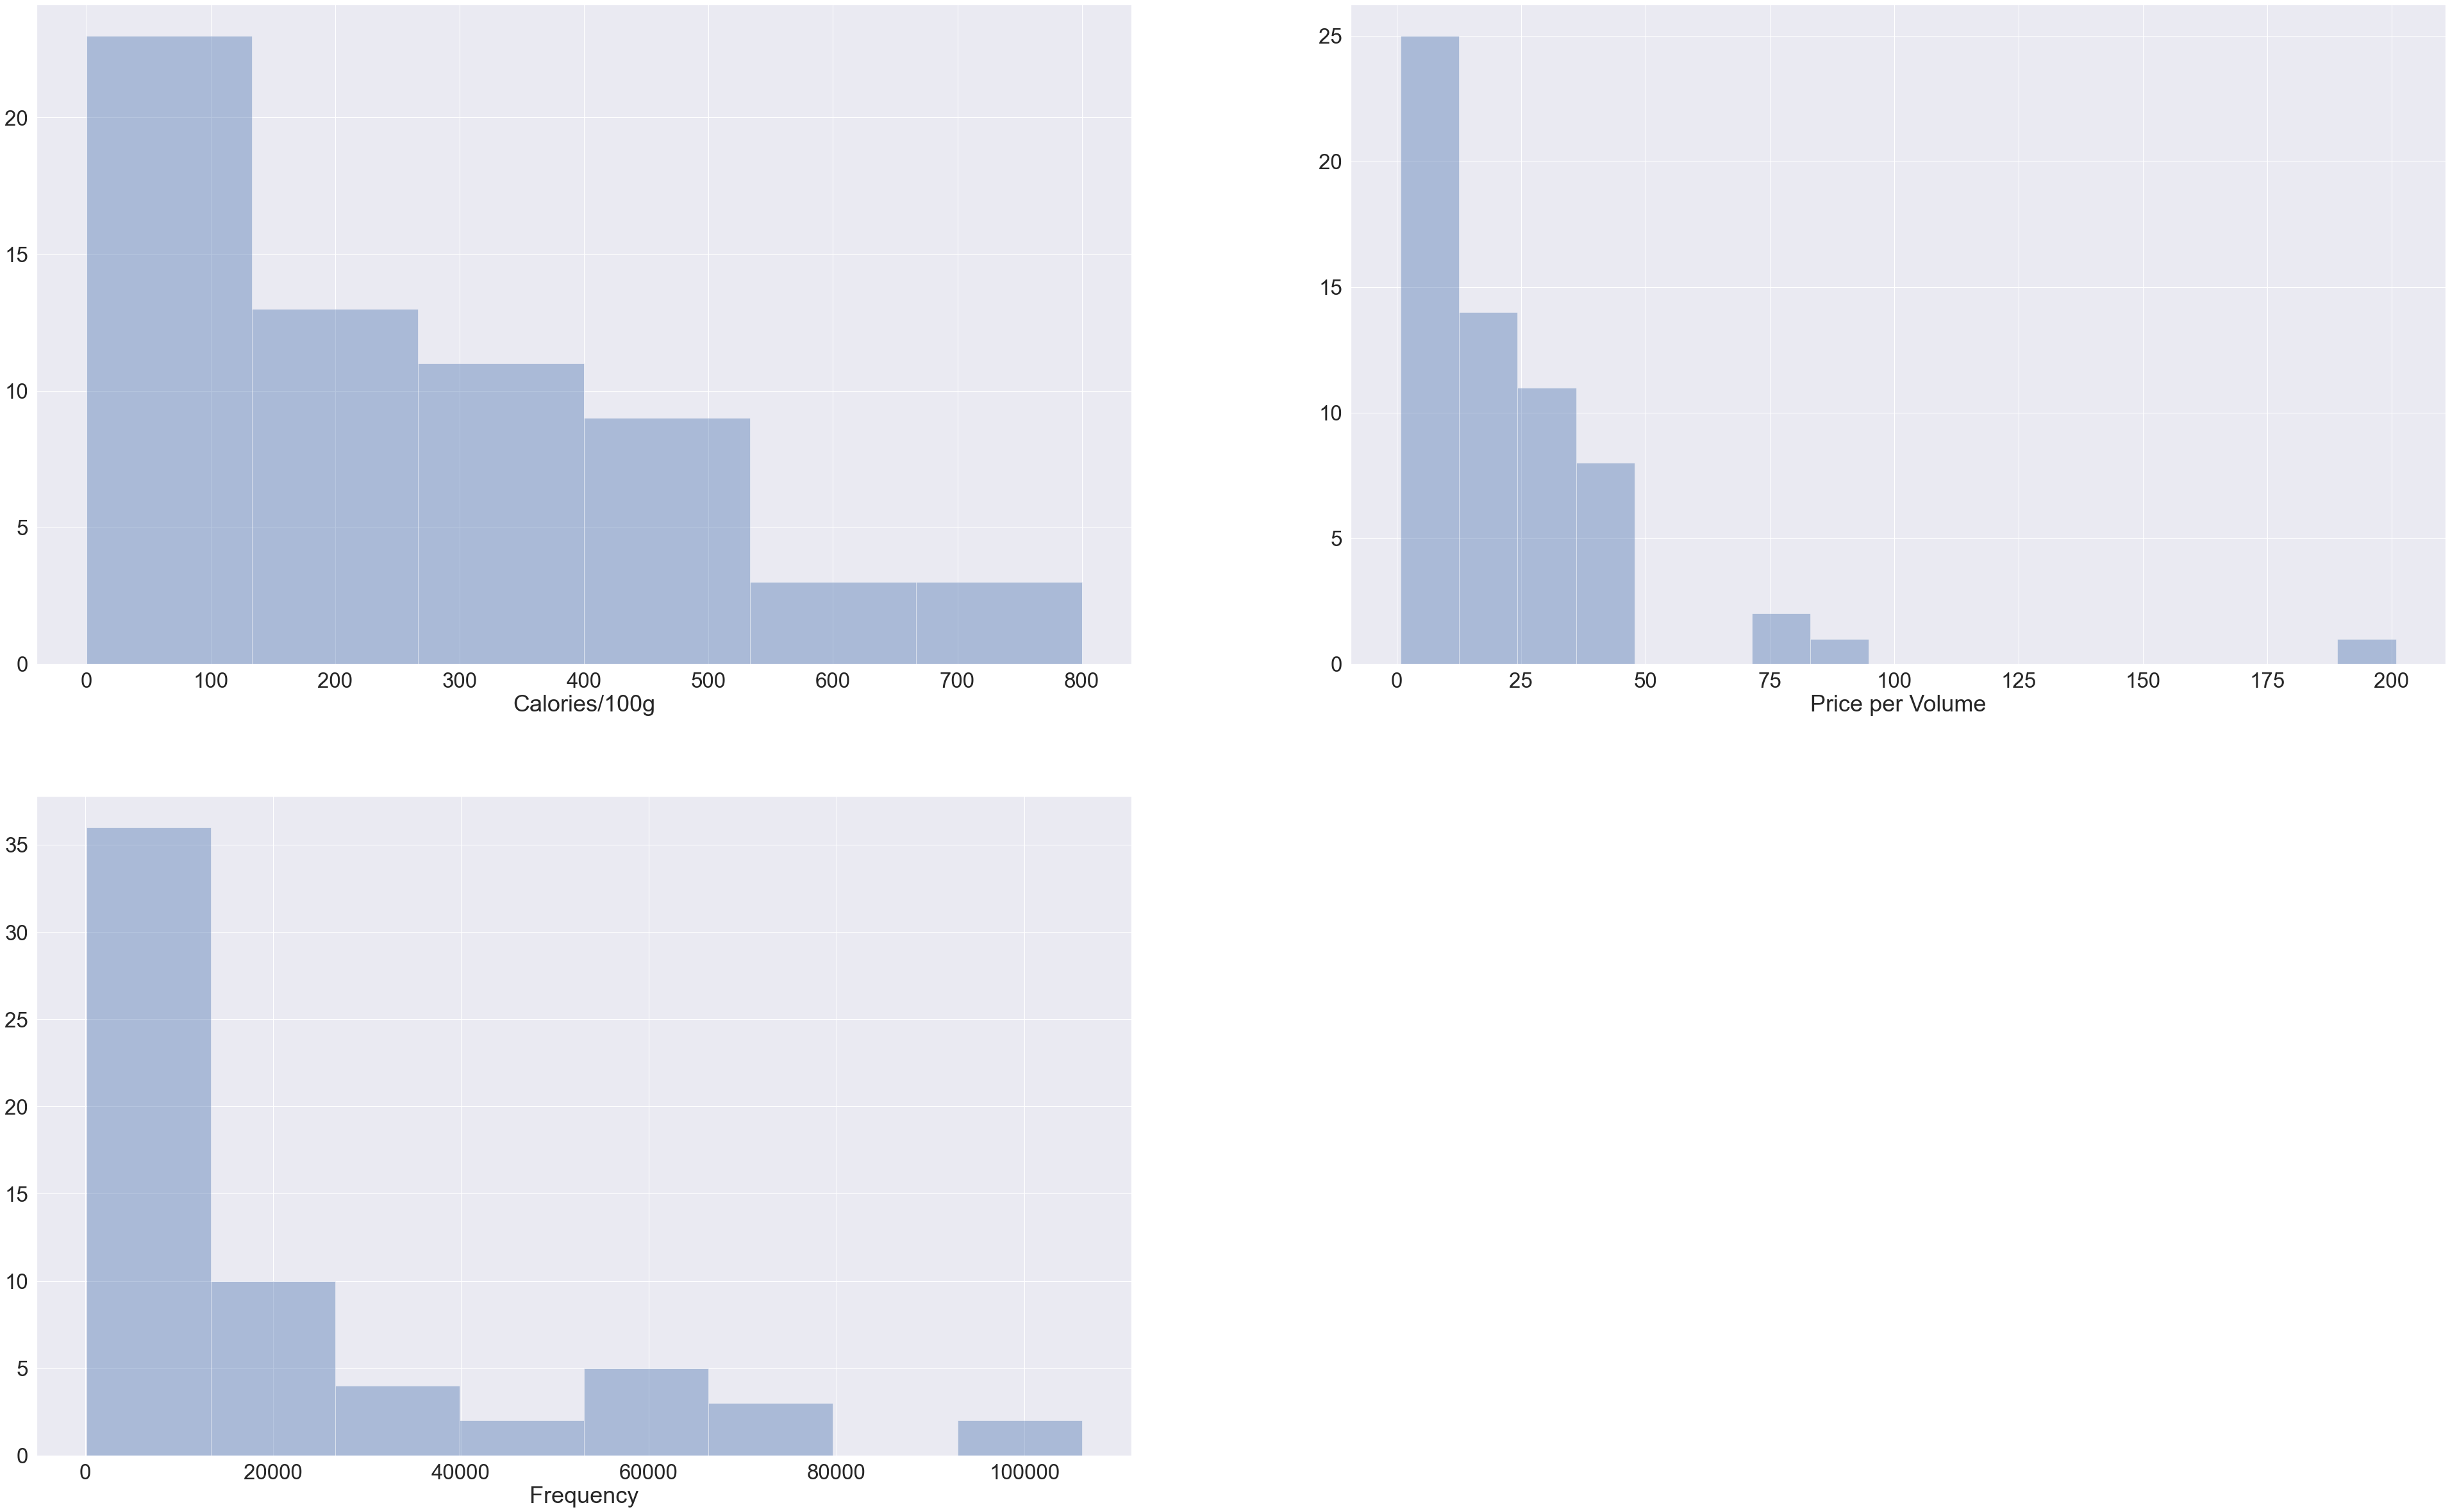

In [ ]:
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(0,3):
    plt.subplot(3,2,i+1)
    freshplot = sns.distplot(Cat.iloc[:,i], kde = False)

In [ ]:
from sklearn.preprocessing import StandardScaler
dataarray = Cat.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

In [ ]:
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

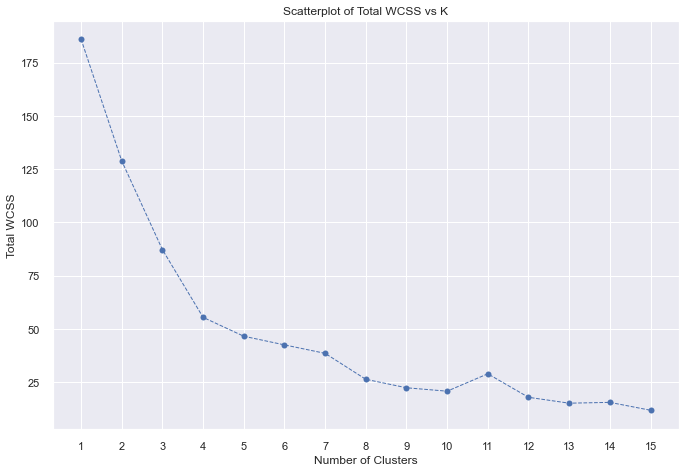

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

print('The elbow is found at ' + str(kl.elbow))

The elbow is found at 4


## Optimising the KMeans algorithm

In this section, we will be testing k at 3 and 4 to find the appropriate number of clusters. 

In [ ]:
kmeans3 = KMeans(init="random",n_clusters =3 , n_init = 10, max_iter = 300, random_state = 42)
kmeans3.fit(scaled_features)
clustergroups3 = kmeans3.labels_ #The cluster number for each row
print("For n_clusters = 3 The average silhouette_score is: " + str(silhouette_score(scaled_features, kmeans3.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 3

For n_clusters = 3 The average silhouette_score is: 0.4125349897580485


In [ ]:
kmeans4 = KMeans(init="random",n_clusters =4 , n_init = 10, max_iter = 300, random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_ #The cluster number for each row
print("For n_clusters = 4 The average silhouette_score is: " + str(silhouette_score(scaled_features, kmeans4.labels_,metric = 'euclidean')))
#The dotted line in the plot represents the Average Silhouette Width for K = 4

For n_clusters = 4 The average silhouette_score is: 0.45032718302773006


From the silhouette score, we should use 4 clusters. 

## Cluster Analysis

In [ ]:
print(kmeans4.inertia_)
'%.1E' % Decimal(kmeans4.inertia_)
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

55.42984620560395


'5.5E+01'

In [ ]:
model_4 = Cat.copy().reset_index()
model_4['Clusters'] = pd.DataFrame(clustergroups4) #Combining the column of clusters to the original dataframe

In [ ]:
model_4.set_index('Category')

Calories/100g  Price per Volume  Frequency  Clusters
Category                                                              
Baby Cereal                 188             29.41       1074         3
Beer                         43             15.12       2671         3
Belacan                     563             39.47       3046         2
Bird Nest                    46             73.45        233         1
Biscuits                    416             15.57     106109         0
...                         ...               ...        ...       ...
Tea                           1             38.68      20832         3
Tonic Food Drink            548             15.21      41030         2
Wine                         83             88.13        242         1
Yoghurt Drink                90              6.47       6533         3
Yoghurts                     61             14.24       7771         3

[62 rows x 4 columns]

In [ ]:
model_4[model_4['Clusters'] == 0]

Category  Calories/100g  Price per Volume  Frequency  Clusters
4              Biscuits            416         15.570000     106109         0
17  Condensed/Evap Milk            321          4.850000      59294         0
19         Cooking Oils            800          3.910000      57568         0
20       Cooking Sauces            175          8.400000      78051         0
26                 Eggs             97          6.166667      94641         0
28                Flour            364          2.870000      43909         0
29          Frozen Food            233         12.280000      56359         0
34      Instant Noodles            431         10.600000      71185         0
46                 Rice            171          3.040000      65669         0
52                Snack            300         23.510000      70211         0
56                Sugar            405          2.940000      63898         0

Below shows the characteristics of each cluster.

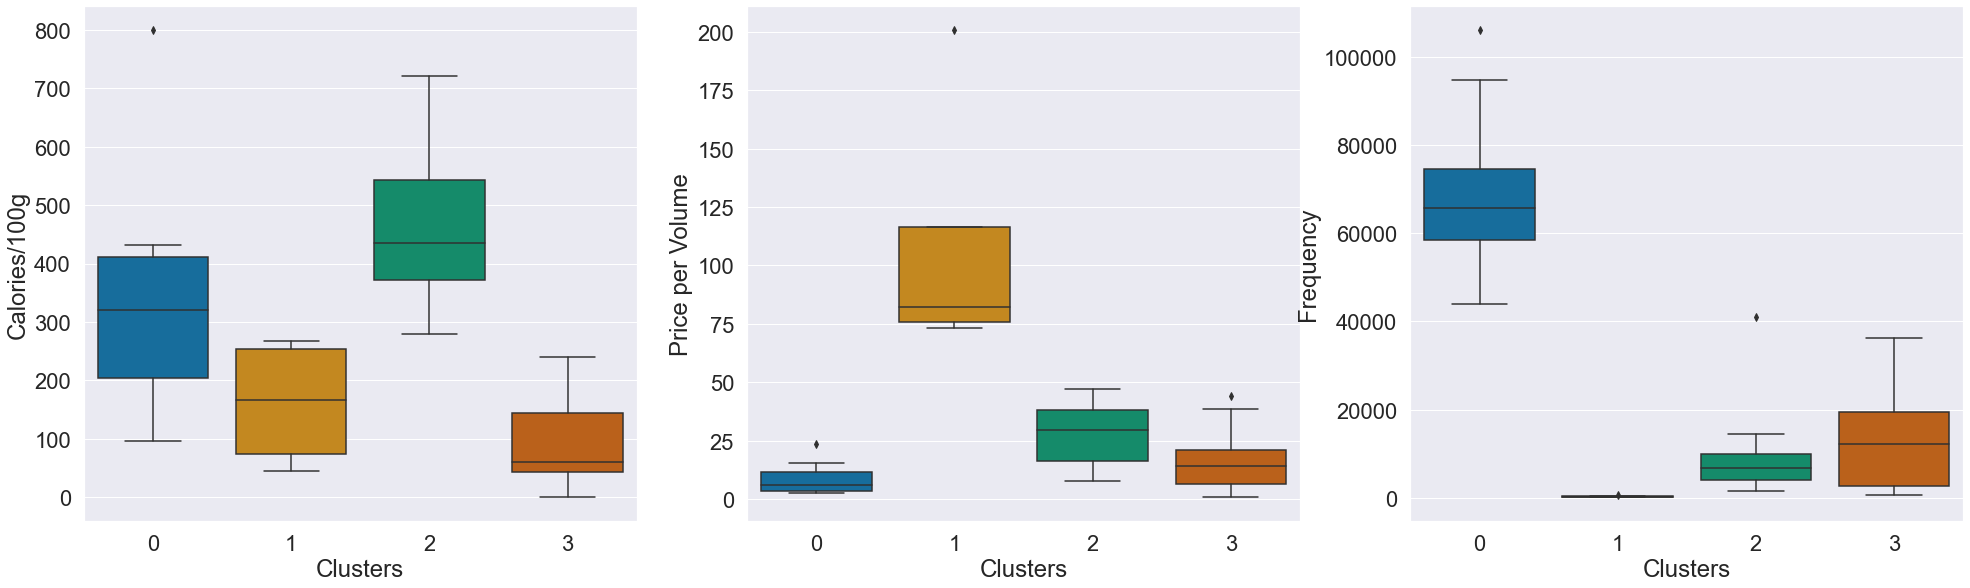

In [ ]:
plt.figure(figsize=(30,30))
sns.set(font_scale = 2)
for i in range(1,4):
    plt.subplot(3,3,i)
    sns.boxplot(y=model_4.columns[i], x='Clusters', data=model_4, palette="colorblind")

3D plot of the categories

In [ ]:
fig = px.scatter_3d(model_4, 
                    x='Calories/100g', 
                    y='Price per Volume', 
                    z='Frequency',
                    color='Clusters', 
                    
                    size_max=18,
              symbol='Clusters', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))